In [1]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
from dateutil.relativedelta import relativedelta
from calendar import monthrange, month_name
from collections import defaultdict, OrderedDict
from pprint import pprint

import subprocess
import pandas as pd

In [13]:
# Elasticsearch should be running at this URL, otherwise the next command will give and error
ES_URL = "http://localhost:9200" 

es = Elasticsearch(ES_URL)

# URL of the repository to be analysed
repository_url = "https://github.com/Cloud-CV/EvalAI.git"

# Names of the indices by which the repository will be stored
enriched_index_name = "cloud_git"
raw_index_name = "cloud_git_raw"

In [14]:
subprocess.run(['p2o.py', '--enrich', '--index', raw_index_name,
      '--index-enrich', enriched_index_name, '-e', ES_URL,
      '--no_inc', '--debug', 'git', repository_url])

CompletedProcess(args=['p2o.py', '--enrich', '--index', 'cloud_git_raw', '--index-enrich', 'cloud_git', '-e', 'http://localhost:9200', '--no_inc', '--debug', 'git', 'https://github.com/Cloud-CV/EvalAI.git'], returncode=0)

In [20]:
query_res = es.search(index=enriched_index_name, body={"query":{"match_all":{}}})
total = query_res["hits"]["total"]
total

908

In [22]:
es.search(index=enriched_index_name, body={"query":{"match_all":{}}})

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': '6fda5d606c80de7d2f05bbc06ce0d3868be4de00',
    '_index': 'cloud_git',
    '_score': 1.0,
    '_source': {'Author': 'Deshraj <deshrajdry@gmail.com>',
     'Committer': 'Deshraj <deshrajdry@gmail.com>',
     'author_date': '2016-10-20T23:58:12',
     'author_domain': 'gmail.com',
     'author_name': 'Deshraj',
     'commit_date': '2016-10-20T23:58:12',
     'committer_domain': 'gmail.com',
     'committer_name': 'Deshraj',
     'files': 2,
     'github_repo': 'Cloud-CV/EvalAI',
     'grimoire_creation_date': '2016-10-20T23:58:12-04:00',
     'hash': '114d7336902e186238ae34e3642e36f592b53c35',
     'hash_short': '114d73',
     'is_git_commit': 1,
     'lines_added': 109,
     'lines_changed': 110,
     'lines_removed': 1,
     'message': 'README and contribution guidelines updated',
     'message_analyzed': 'README and contribution guidelines updated',
     'metadata__enriched_on': '2018-03-2

In [84]:
def commit_records(index=None):
    "Queries the elasticsearch instance and returns all the documents in the index."
    
    search_result = es.search(index=index, body={"query":{"match_all":{}}})
    total = search_result["hits"]["total"]
    query = {
                "size":total, 
                "query":
                        {
                            "match_all":{}
                        }
    }
    query_result = es.search(index=index, body=query)
    results = [query_result["hits"]["hits"][i]["_source"] for i in range(query_result["hits"]["total"])]
    return results

In [85]:
results = commit_records(enriched_index_name)

In [130]:
results[907]

{'Author': 'Deshraj Yadav <deshraj@gatech.edu>',
 'Committer': 'GitHub <noreply@github.com>',
 'author_date': '2018-03-23T15:11:43',
 'author_domain': 'gatech.edu',
 'author_name': 'Deshraj Yadav',
 'commit_date': '2018-03-23T15:11:43',
 'committer_domain': 'github.com',
 'committer_name': 'GitHub',
 'files': 1,
 'github_repo': 'Cloud-CV/EvalAI',
 'grimoire_creation_date': '2018-03-23T15:11:43-04:00',
 'hash': 'cb2aeec971286fd6aa18437f247f9b565aef38f3',
 'hash_short': 'cb2aee',
 'is_git_commit': 1,
 'lines_added': 1,
 'lines_changed': 2,
 'lines_removed': 1,
 'message': 'Frontend: Allow zip file submission in a challenge (#1592)',
 'message_analyzed': 'Frontend: Allow zip file submission in a challenge (#1592)',
 'metadata__enriched_on': '2018-03-25T17:32:56.921001',
 'metadata__gelk_backend_name': 'GitEnrich',
 'metadata__gelk_version': '0.30.23',
 'metadata__timestamp': '2018-03-25T12:02:50.204860+00:00',
 'metadata__updated_on': '2018-03-23T19:11:43+00:00',
 'offset': None,
 'origin

In [34]:
import elasticsearch_dsl

In [76]:
# Build a DSL Search object on the 'commits' index, 'summary' document type
request = elasticsearch_dsl.Search(using=es, index='cloud_git')

In [77]:
response = request.scan()

In [80]:
total = request.count()
print("Count of total number of commits in index: ", total)

Count of total number of commits in index:  908


In [79]:
for commit in response:
    print(commit.hash, commit.author_date, commit.author_name)

cacb92cf1e49d916b9b0a6131b0923a1188ca024 2016-10-21T06:46:36 Deshraj
77c390b7f0b9541984ec37b88a77cd8958895fd8 2016-10-20T22:25:05 Deshraj
50b025de973fa72a81f8a9ad7969605d2515f3bd 2016-10-20T20:51:45 Deshraj Yadav
e7dea2c3356288251a2f1fd365a9727dcaae3cc1 2016-10-20T22:25:41 Deshraj
cb6dd7d9cc09032eb5ca12ecf4b08736917a5ddd 2016-11-02T00:09:33 Harsh Agrawal
6ff840c26c2ef3368a8b7c7c8560be1d9dfe19c3 2016-10-21T07:19:51 Deshraj
e1dfd1f8b41bb8e8e116b3443e08085aa3154aa6 2016-10-20T23:03:52 Deshraj
9868037dff08d27280a99d581de064fd8a101520 2016-10-20T20:52:29 Deshraj
9f425fddf275704a57b10bedeec3a91386028180 2016-10-20T22:40:28 Deshraj
1fb6c1c9ea446d7589cfdc5ece105f447d37367d 2016-11-02T00:16:49 Harsh Agrawal
94aac97e9c5fc2db70eb80efce8b68cbfec5e6f7 2016-11-02T02:20:49 Harsh Agrawal
b37ae3dfffb52cafd3c4ff3a70c094071997299b 2016-10-20T20:10:50 Deshraj Yadav
ce0bce37dc4ee6b9d7ba57b0a6cf0dfe2e81cc23 2016-10-20T22:28:35 Deshraj
9020a8591c987df5f0333a797ab39e733c8b1925 2016-10-21T08:40:31 Deshraj Yada

1d7f086d103167c30caed45af52951dad29a0080 2017-08-11T13:16:19 rishabhjain
ded58a0fadb19df693111b6eac44e9cc76493772 2017-08-09T15:50:49 Harshit Dwivedi
4a7f3850ab11f4165e36cd585b2e80df44c03aa5 2017-07-19T04:43:51 Taranjeet Singh
586aa2e27a1652e214ebbe92d7bf1b8945c6d488 2018-01-27T03:46:04 rishabhjain
b33876116a927f015eadfa67fc86d47b24fe6414 2017-10-16T12:21:46 Deshraj Yadav
702e1f02a8666f9de312ffd46dff1d2d0803131c 2017-08-14T10:24:25 Taranjeet Singh
4217fca95b55efc6a29c6302b0229821f5fc4999 2017-08-09T16:29:48 Shiv Baran Singh
bab09b06904db86a4cc707059af2816f069aef37 2017-07-23T03:44:42 rishabhjain
47673443a988c4a0664fe46e26827d5eb98ee246 2017-09-17T03:19:06 RishabhJain2018
992ce9c8fcc6f5117889ccadc49d32bc0c3a4e52 2017-10-19T12:15:35 Adarsh S
e378c5d6fd6a2f5d1ec020198eeae5d17793952f 2017-08-14T10:36:33 Akash Jain
1c5b083affaf36e10d3852ac02ba4a06fd52b837 2017-08-25T02:23:28 rishabhjain
0db29d9346acb8107155dd89afd51e6bc382c195 2017-07-23T04:04:28 rishabhjain
c043cd1dda35afa82b9c238e1f00e1e1

In [87]:
def parse_date(date, custom_format=None):
    """Returns a datetime.datetime object from a string. 
    custom_format for the date can be given as input"""
    
    if custom_format:
        return datetime.strptime(date, custom_format)
    
    return datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")

In [88]:
def get_end_date_of_month(date):
    "Given a date, return the end date of the month"
    
    return date + relativedelta(days = +(monthrange(date.year, date.month)[1] - date.day))

In [89]:
def get_start_date_of_month(date):
    "Given a date, return the start date of the month"
    
    return date - relativedelta(days = +date.day-1)

In [90]:
def get_bucket_name(date):
    "Given a date return the a string in the form of Month-YYYY"
    
    return month_name[date.month] + "-" + str(date.year)

In [91]:
def get_extreme_commits_dates(commit_list):
    "Given a list of commits, return the dates of the first and the last commits"
    
    fc_date = min(parse_date(item['commit_date']) for item in commit_list)
    lc_date = max(parse_date(item['commit_date']) for item in commit_list)
    return fc_date, lc_date

In [92]:
def make_buckets(first_date, last_date):
    """Given the project start date and the last commit date, return 
    containers for months in between those dates. Each container is a month 
    containing details about all the commits and committers for that month."""
    
    buckets = OrderedDict()
    
    month_start_date = get_start_date_of_month(first_date)
    month_end_date = get_end_date_of_month(first_date)
    bucket_name = get_bucket_name(first_date)
    
    while month_end_date <= last_date:
        commit = {}
        commit['new_committers'] = defaultdict(int)
        commit['old_committers'] = defaultdict(int)
        commit['commits'] = []
        buckets[bucket_name] = commit
        
        month_start_date = month_end_date + relativedelta(days=+1)
        month_end_date = get_end_date_of_month(month_start_date)
        bucket_name = get_bucket_name(month_start_date)
    
    commit = {}
    commit['new_committers'] = defaultdict(int)
    commit['old_committers'] = defaultdict(int)
    commit['commits'] = []
    buckets[bucket_name] = commit
    
    return buckets

In [93]:
def analyse_repository(commit_list):
    
    first_date, last_date = get_extreme_commits_dates(commit_list)
    
    months = make_buckets(first_date, last_date)
    
    for commit in commit_list:
        month = get_bucket_name(parse_date(commit['commit_date']))
        months[month]["commits"].append(commit)
        
    all_committers = []
    
    for name, month in months.items():
        for commit in month['commits']:
            committer = commit['author_name']
            if committer in all_committers:
                month['old_committers'][committer] += 1
            else:
                month['new_committers'][committer] += 1
        all_committers = list(set(all_committers + list(month['old_committers'].keys()) + 
                                  list(month['new_committers'].keys())))
        del month['commits']
                
    return months

In [94]:
Output = analyse_repository(results)

In [96]:
format_template = '{:<25}{}'

print(format_template.format('Month', 'No. of new committers'))

for month_name, month in Output.items():
    if len(month["new_committers"]) != 0:
        print(format_template.format(month_name, len(month["new_committers"])))

Month                    No. of new committers
October-2016             2
November-2016            9
December-2016            2
January-2017             6
February-2017            3
March-2017               8
April-2017               2
May-2017                 2
August-2017              3
September-2017           5
October-2017             8
November-2017            5
December-2017            7
January-2018             7
February-2018            1
March-2018               3


In [104]:
def data_from_dict(commit_dict):
    data = []
    for month_name, month in commit_dict.items():
        item_list = []
        for key, val in month['new_committers'].items():
            item = {}
            item['month'] = month_name
            item["Author of commit"] = key
            item['Number of commits'] = val
            item_list.append(item)
        data = data + item_list
    
    return pd.DataFrame(data)

In [115]:
final_data = data_from_dict(Output)

In [116]:
final_data

,Author of commit,Number of commits,month
0,Deshraj,11,October-2016
1,Deshraj Yadav,3,October-2016
2,Harsh Agrawal,12,November-2016
3,Taranjeet Singh,46,November-2016
4,Akash Jain,13,November-2016
5,rishabhjain,4,November-2016
6,arun jain,3,November-2016
7,Gautham Santhosh,1,November-2016
8,The Gitter Badger,1,November-2016
9,Anwesh Nayak,3,November-2016


In [120]:
no_of_new_commiters_per_month = final_data.groupby('month').count().drop('Number of commits', axis=1)

In [123]:
no_of_new_commiters_per_month.rename(columns = {'Author of commit': 'Number of new commiters'},inplace =True)

In [124]:
no_of_new_commiters_per_month

,Number of new commiters
month,
April-2017,2
August-2017,3
December-2016,2
December-2017,7
February-2017,3
February-2018,1
January-2017,6
January-2018,7
March-2017,8


In [107]:
final_data.to_csv(enriched_index_name + ".csv", index=False)

In [125]:
no_of_new_commiters_per_month.to_csv(enriched_index_name + "new commiters per month" + ".csv", index=False)

PANDAS APPROACH

In [206]:
repo_data = pd.DataFrame(results)

In [208]:
repo_data.head()

,Author,Committer,author_date,author_domain,author_name,commit_date,committer_domain,committer_name,files,github_repo,...,offset,origin,repo_name,tag,title,tz,url_id,utc_author,utc_commit,uuid
0,Deshraj <deshrajdry@gmail.com>,Deshraj <deshrajdry@gmail.com>,2016-10-20T23:58:12,gmail.com,Deshraj,2016-10-20T23:58:12,gmail.com,Deshraj,2,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,README and contribution guidelines updated,-4,Cloud-CV/EvalAI/commit/114d7336902e186238ae34e...,2016-10-21T03:58:12,2016-10-21T03:58:12,6fda5d606c80de7d2f05bbc06ce0d3868be4de00
1,Harsh Agrawal <h.agrawal092@gmail.com>,Harsh Agrawal <h.agrawal092@gmail.com>,2016-11-02T00:09:33,gmail.com,Harsh Agrawal,2016-11-02T00:09:33,gmail.com,Harsh Agrawal,4,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,Updating configurations for third-party integr...,-5,Cloud-CV/EvalAI/commit/cb6dd7d9cc09032eb5ca12e...,2016-11-02T05:09:33,2016-11-02T05:09:33,fe5b3f52c5e12d30e26883768ba6e1b3f01493f0
2,Harsh Agrawal <h.agrawal092@gmail.com>,Harsh Agrawal <h.agrawal092@gmail.com>,2016-11-02T00:16:49,gmail.com,Harsh Agrawal,2016-11-02T00:16:49,gmail.com,Harsh Agrawal,4,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,Adding some testing support,-5,Cloud-CV/EvalAI/commit/1fb6c1c9ea446d7589cfdc5...,2016-11-02T05:16:49,2016-11-02T05:16:49,6755e27cf048db3556eea1f54f3f775ec2ff5c71
3,Deshraj <deshrajdry@gmail.com>,Deshraj <deshrajdry@gmail.com>,2016-11-03T19:52:18,gmail.com,Deshraj,2016-11-03T19:52:18,gmail.com,Deshraj,1,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,typo fix,-4,Cloud-CV/EvalAI/commit/e4d5528b471f9b03e529ea6...,2016-11-03T23:52:18,2016-11-03T23:52:18,1f2f7494a8a080fbd5bc34958ee5928e3418fbb0
4,Deshraj <deshrajdry@gmail.com>,Deshraj <deshrajdry@gmail.com>,2016-11-04T06:46:43,gmail.com,Deshraj,2016-11-04T06:46:43,gmail.com,Deshraj,1,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,requirements updated for production environment,-4,Cloud-CV/EvalAI/commit/469929c52ad220ecb2d0d19...,2016-11-04T10:46:43,2016-11-04T10:46:43,7260c130fba325a46bc665958cf225bd631b8cd0


In [154]:
repo_data.drop(repo_data.columns.difference(['commit_date','committer_name']), axis=1, inplace = True)

In [155]:
repo_data.dtypes

commit_date       object
committer_name    object
dtype: object

In [156]:
repo_data.commit_date = pd.to_datetime(repo_data.commit_date)

In [157]:
repo_data.dtypes

commit_date       datetime64[ns]
committer_name            object
dtype: object

In [158]:
repo_data.set_index('commit_date', inplace=True)

In [159]:
group=repo_data.groupby(pd.TimeGrouper("M"))

In [160]:
list(group)[0]

(Timestamp('2016-10-31 00:00:00', offset='M'),
                     committer_name
 commit_date                       
 2016-10-20 20:10:50         GitHub
 2016-10-20 20:51:45  Deshraj Yadav
 2016-10-20 20:52:29        Deshraj
 2016-10-20 22:25:05        Deshraj
 2016-10-20 22:25:41        Deshraj
 2016-10-20 22:28:35        Deshraj
 2016-10-20 22:40:28        Deshraj
 2016-10-20 23:03:52        Deshraj
 2016-10-20 23:58:12        Deshraj
 2016-10-21 06:46:36        Deshraj
 2016-10-21 07:19:51        Deshraj
 2016-10-21 07:37:35        Deshraj
 2016-10-21 08:40:31         GitHub
 2016-10-21 09:19:11        Deshraj)

In [163]:
group.committer_name.value_counts()

commit_date  committer_name  
2016-10-31   Deshraj             11
             GitHub               2
             Deshraj Yadav        1
2016-11-30   Deshraj Yadav       74
             GitHub              29
             Deshraj             20
             Harsh Agrawal       17
2016-12-31   Deshraj Yadav       54
             GitHub              18
2017-01-31   Deshraj Yadav       86
             GitHub              60
             Akash Jain          16
             Taranjeet Singh      4
             Shiv Baran Singh     1
2017-02-28   Deshraj Yadav       28
             GitHub              23
             Akash Jain          16
             Shiv Baran Singh     5
2017-03-31   GitHub              23
             Akash Jain          18
             Deshraj Yadav       17
             Shiv Baran Singh     8
             Taranjeet Singh      6
             Deshraj              4
             akashjain993         3
2017-04-30   GitHub              47
             Deshraj Yadav       1

In [164]:
group.committer_name.nunique()

commit_date
2016-10-31    3
2016-11-30    4
2016-12-31    2
2017-01-31    5
2017-02-28    4
2017-03-31    7
2017-04-30    3
2017-05-31    4
2017-06-30    3
2017-07-31    2
2017-08-31    3
2017-09-30    3
2017-10-31    5
2017-11-30    5
2017-12-31    3
2018-01-31    5
2018-02-28    5
2018-03-31    5
Freq: M, Name: committer_name, dtype: int64

In [165]:
commiters_group=repo_data.groupby('committer_name')

In [184]:
commit_count=commiters_group.committer_name.count()

In [185]:
commit_count

committer_name
Akash Jain           65
DESHRAJ               6
Deshraj              42
Deshraj Yadav       433
GitHub              264
Harsh Agrawal        17
RishabhJain2018      17
Shiv Baran Singh     21
Taranjeet Singh      30
akashjain993          3
geekayush             2
rishabhjain           6
spyshiv               1
xamfy                 1
Name: committer_name, dtype: int64

In [176]:
commiters_group.committer_name.count().sum()

908

In [186]:
df=pd.DataFrame({'committer name':commit_count.index, 'commit count':commit_count.values})

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

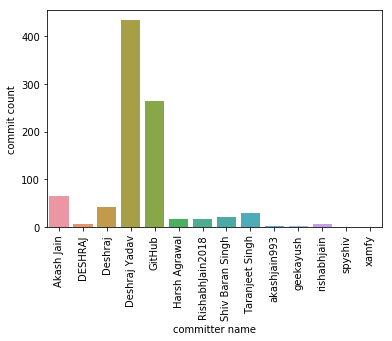

In [204]:
graph=sns.barplot(x="committer name", y="commit count", data=df)
for item in graph.get_xticklabels():
    item.set_rotation(90)